In [4]:
import numpy as np

def blue_analysis(xb, y, H, B, R):
    """
    xb (Nx, 1)
    y (Ny, 1)
    H (Ny, Nx)
    B (Nx, Nx)
    R (Ny, Ny)
    xa  (Nx, 1)
    Pa (Nx, Nx)
    """
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    xa = xb + K @ (y - H @ xb)
    Pa = (np.eye(len(xb)) - K @ H) @ B

    return xa, Pa

Analysis state estimate (xa):
[[1.33333333]
 [1.        ]
 [2.        ]]

Analysis error covariance (Pa):
[[ 0.03333333  0.          0.        ]
 [ 0.          0.06       -0.04      ]
 [ 0.         -0.04        0.06      ]]


## On s'interesse au système d'un pendule simple.
Ici Nx = 2, Ny = 1

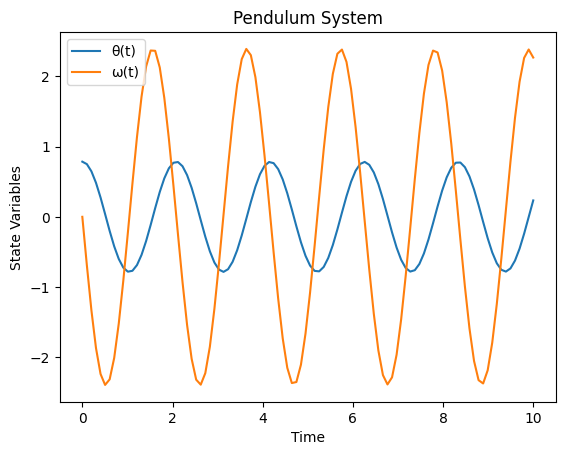

(2,)


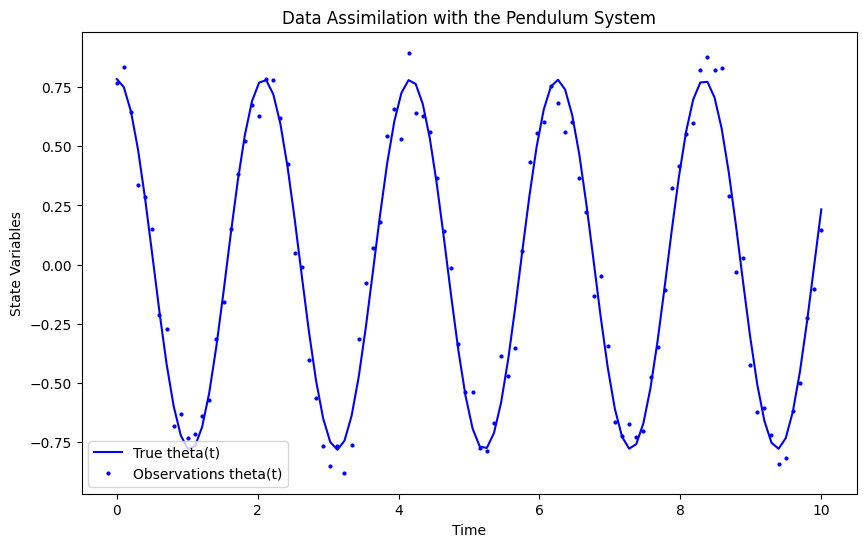

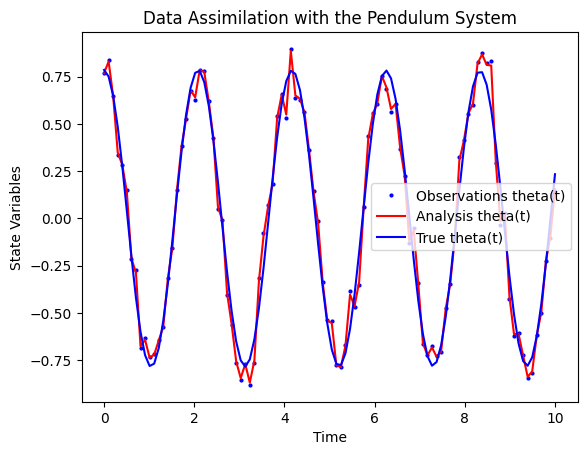

In [106]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# On définit les équations de notre système physique.
def pendulum_system(t, state, g=9.81, l=1.0):
    theta = state[0]
    omega = state[1]
    dtheta_dt = omega
    domega_dt = -(g / l) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# On définit les  conditions initiales.
initial_state = [np.pi / 4, 0.0]

# On définit le temps sur lequel on veut résoudre les équations.
t_span = (0, 10)
# On définit les temps sur lesquels on veut évaluer notre solution.
t_eval = np.linspace(0, 10, 100)

# On résout.
sol = solve_ivp(pendulum_system, t_span, initial_state, t_eval=t_eval)

# Plot de la solution.
plt.plot(sol.t, sol.y[0], label='θ(t)')
plt.plot(sol.t, sol.y[1], label='ω(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Pendulum System')
plt.show()


# On génère des observations. On les bruite pour plus de réalismes en ajoutant un bruit gaussien centré.
observation_noise_std = 0.1
observations = sol.y[0] + np.random.normal(0, observation_noise_std, sol.y[0].shape)



def blue_analysis(xb, y, H, B, R):
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    xa = xb + K @ (y - H @ xb)
    Pa = (np.eye(len(xb)) - K @ H) @ B @ (np.eye(len(xb)) - K @ H).T + K @ R @ K.T
    return xa, Pa

# On définit les matrices d'interêts pour le BLUE.
H = np.array([[1, 0]])  # On oberserve que l'angle theta.
B = np.diag([0.1, 0.1])
R = np.array([[observation_noise_std**2]])

# On résout avec le BLUE.
xa_list = []
Pa_list = []

for i in range(len(t_eval)):
    xb = sol.y[:, i]
    y = observations[i]
    xa, Pa = blue_analysis(xb, y, H, B, R)
    xa_list.append(xa)
    Pa_list.append(Pa)

xa_array = np.array(xa_list)

# On plot nos résultats.
plt.figure(figsize=(10, 6))

plt.plot(sol.t, sol.y[0], label='True theta(t)', color='blue')
plt.plot(sol.t, observations, 'o', label='Observations theta(t)', color='blue', markersize=2)

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Pendulum System')
plt.show()

plt.plot(sol.t, observations, 'o', label='Observations theta(t)', color='blue', markersize=2)
plt.plot(sol.t, xa_array[:, 0], label='Analysis theta(t)', color='red')
plt.plot(sol.t, sol.y[0], label='True theta(t)', color='blue')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Pendulum System')
plt.show()


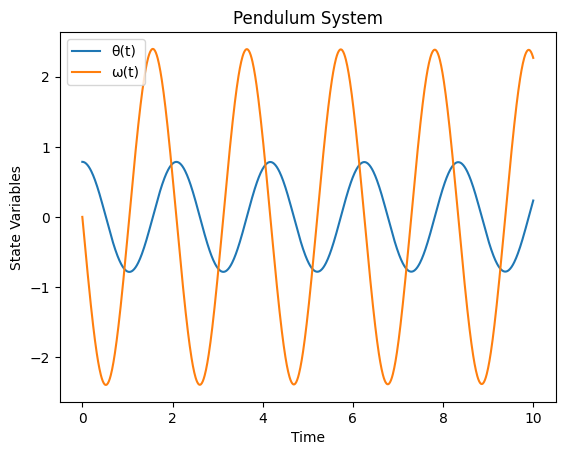

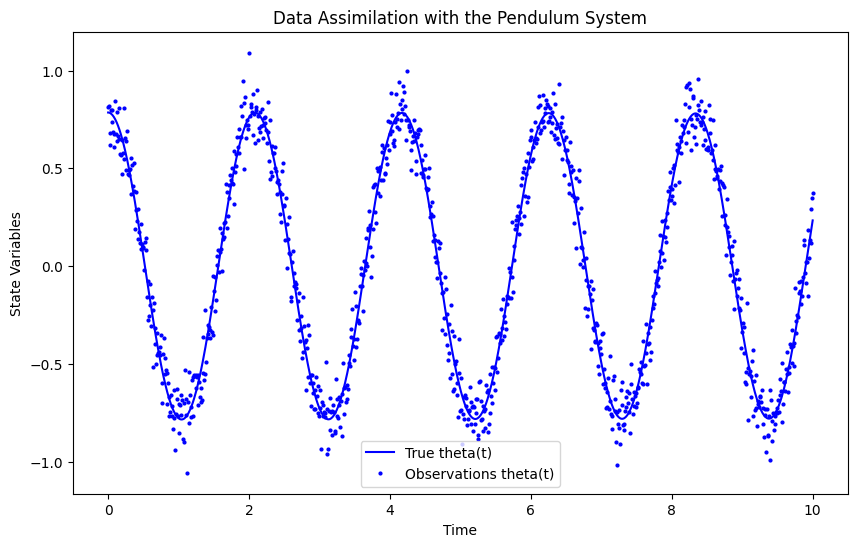

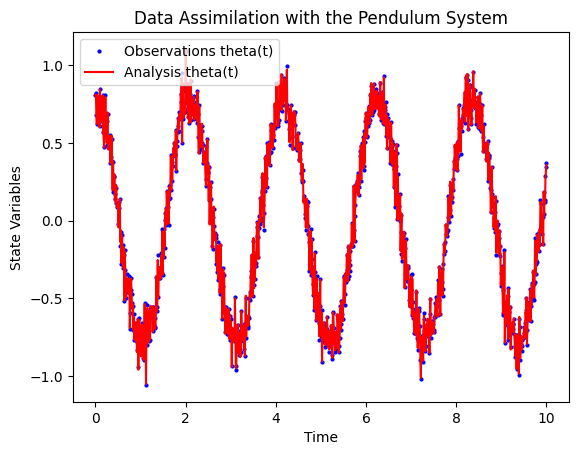

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# On définit les équations de notre système physique.
def pendulum_system(t, state, g=9.81, l=1.0):
    theta = state[0]
    omega = state[1]
    dtheta_dt = omega
    domega_dt = -(g / l) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# On définit les  conditions initiales.
initial_state = [np.pi / 4, 0.0]

# On définit le temps sur lequel on veut résoudre les équations.
t_span = (0, 10)
# On définit les temps sur lesquels on veut évaluer notre solution.
t_eval = np.linspace(0, 10, 1000)

# On résout.
sol = solve_ivp(pendulum_system, t_span, initial_state, t_eval=t_eval)

# Plot de la solution.
plt.plot(sol.t, sol.y[0], label='θ(t)')
plt.plot(sol.t, sol.y[1], label='ω(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Pendulum System')
plt.show()


# On génère des observations. On les bruite pour plus de réalismes en ajoutant un bruit gaussien centré.
observation_noise_std = 0.1
observations = sol.y[0] + np.random.normal(0, observation_noise_std, sol.y[0].shape)



def blue_analysis(xb, y, H, B, R):
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    xa = xb + K @ (y - H @ xb)
    Pa = (np.eye(len(xb)) - K @ H) @ B @ (np.eye(len(xb)) - K @ H).T + K @ R @ K.T
    return xa, Pa

# On définit les matrices d'interêts pour le BLUE.
H = np.array([[1, 0]])  # On oberserve que l'angle theta.
B = np.diag([1, 1])
R = np.array([[observation_noise_std**2]])

# On résout avec le BLUE.
xa_list = []
Pa_list = []
xb = initial_state + np.random.normal(0, 0.1, 2)
xa = xb
for i in range(len(t_eval)):
    if i > 0:
        state = xa
        dt = t_eval[i] - t_eval[i-1]
        derivatives = pendulum_system(t_eval[i], state)
        xb = state + np.array(derivatives) * dt  # On utilise euler pour le background au lieu de prendre directement la ground_truth.
        xb = xb + np.random.normal(0, 1, 2)
    y = observations[i]
    xa, Pa = blue_analysis(xb, y, H, B, R)
    xa_list.append(xa)
    Pa_list.append(Pa)

xa_array = np.array(xa_list)


# On plot nos résultats.
plt.figure(figsize=(10, 6))

plt.plot(sol.t, sol.y[0], label='True theta(t)', color='blue')
plt.plot(sol.t, observations, 'o', label='Observations theta(t)', color='blue', markersize=2)

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Pendulum System')
plt.show()

plt.plot(sol.t, observations, 'o', label='Observations theta(t)', color='blue', markersize=2)
plt.plot(sol.t, xa_array[:, 0], label='Analysis theta(t)', color='red')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Pendulum System')
plt.show()


### On complique un peu en s'interessant au système d'attraction de Lorentz.
Ici Nx = 3, Ny = 2 .

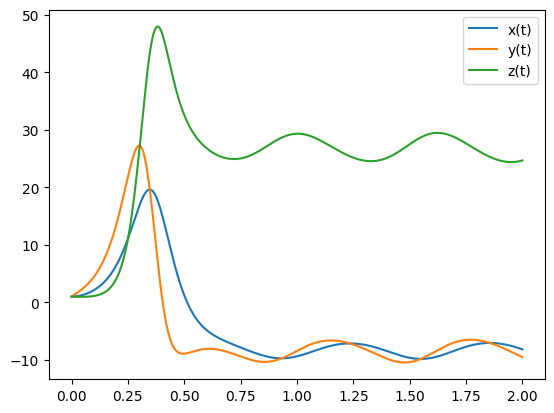

In [28]:
def lorenz_system(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = rho * x - y - x * z
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]


initial_state = [1.0, 1.0, 1.0]

t_span = (0, 2)
t_eval = np.linspace(0, 2, 1000)
sol = solve_ivp(lorenz_system, t_span, initial_state, t_eval=t_eval)

plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
plt.plot(sol.t, sol.y[2], label='z(t)')
plt.legend()
plt.show()


In [36]:
def blue_analysis(xb, y, H, B, R):
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    xa = xb + K @ (y - H @ xb)
    Pa = (np.eye(len(xb)) - K @ H) @ B @ (np.eye(len(xb)) - K @ H).T + K @ R @ K.T
    return xa, Pa

observation_noise_std = 2.0
observations = sol.y[:2] + np.random.normal(0, observation_noise_std, sol.y[:2].shape)

H = np.array([[1, 0, 0],
              [0, 1, 0]])
B = np.diag([0.5, 0.5, 0.5])
R = np.diag([observation_noise_std**2, observation_noise_std**2])
xa_list = []
Pa_list = []
xb = initial_state + np.random.normal(0, 1, 3)
xa = xb
for i in range(len(t_eval)):
    if i > 0:
        state = xa
        dt = t_eval[i] - t_eval[i-1]
        derivatives = lorenz_system(t_eval[i], state)
        xb = state + np.array(derivatives) * dt
        xb = xb + np.random.normal(0, 0.5, 3)
    y = observations[:, i]
    xa, Pa = blue_analysis(xb, y, H, B, R)
    xa_list.append(xa)
    Pa_list.append(Pa)

xa_array = np.array(xa_list)


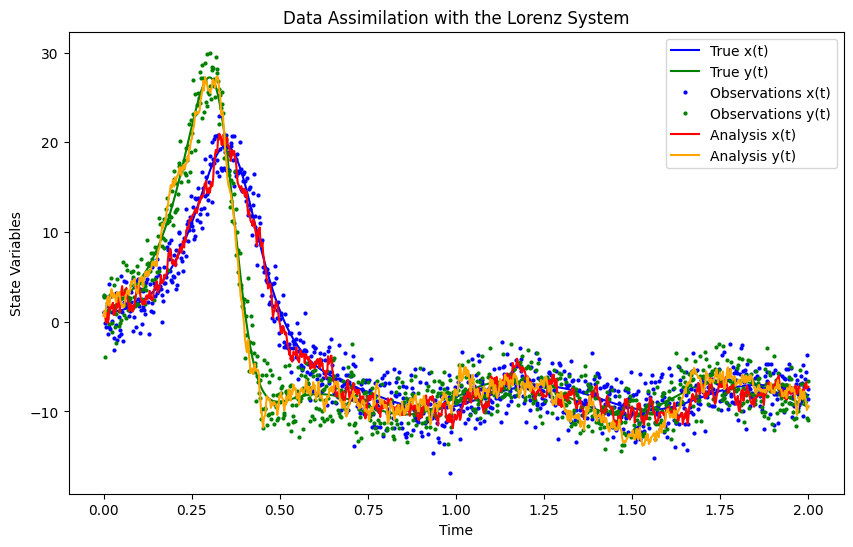

In [37]:

plt.figure(figsize=(10, 6))

plt.plot(sol.t, sol.y[0], label='True x(t)', color='blue')
plt.plot(sol.t, sol.y[1], label='True y(t)', color='green')
plt.plot(sol.t, observations[0], 'o', label='Observations x(t)', color='blue', markersize=2)
plt.plot(sol.t, observations[1], 'o', label='Observations y(t)', color='green', markersize=2)
plt.plot(sol.t, xa_array[:, 0], label='Analysis x(t)', color='red')
plt.plot(sol.t, xa_array[:, 1], label='Analysis y(t)', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Lorenz System')
plt.show()


In [40]:
def blue_analysis(xb, y, H, B, R):
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    xa = xb + K @ (y - H @ xb)
    Pa = (np.eye(len(xb)) - K @ H) @ B @ (np.eye(len(xb)) - K @ H).T + K @ R @ K.T
    return xa, Pa


H = np.array([[1, 0, 0],
              [0, 1, 0]])
B = np.diag([0.1, 0.1, 0.1])
R = np.diag([observation_noise_std**2, observation_noise_std**2])
xa_list = []
Pa_list = []
xb = initial_state + np.random.normal(0, 0.1, 3)
xa = xb
for i in range(len(t_eval)):
    xb = sol.y[:, i] + np.random.normal(0, 0.1, 3)
    y = observations[:, i]
    xa, Pa = blue_analysis(xb, y, H, B, R)
    xa_list.append(xa)
    Pa_list.append(Pa)

xa_array = np.array(xa_list)


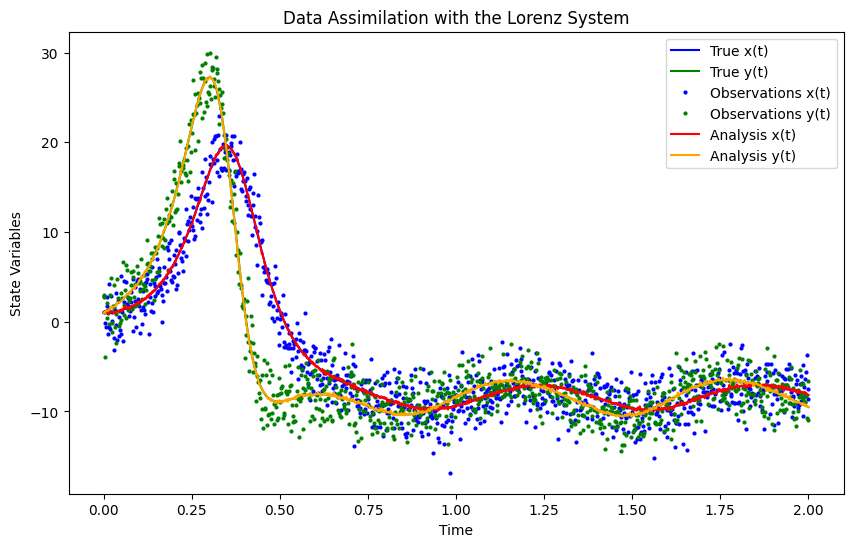

In [41]:

plt.figure(figsize=(10, 6))

plt.plot(sol.t, sol.y[0], label='True x(t)', color='blue')
plt.plot(sol.t, sol.y[1], label='True y(t)', color='green')
plt.plot(sol.t, observations[0], 'o', label='Observations x(t)', color='blue', markersize=2)
plt.plot(sol.t, observations[1], 'o', label='Observations y(t)', color='green', markersize=2)
plt.plot(sol.t, xa_array[:, 0], label='Analysis x(t)', color='red')
plt.plot(sol.t, xa_array[:, 1], label='Analysis y(t)', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Lorenz System')
plt.show()


### On regarde maintenant le méthode 3D_Var.

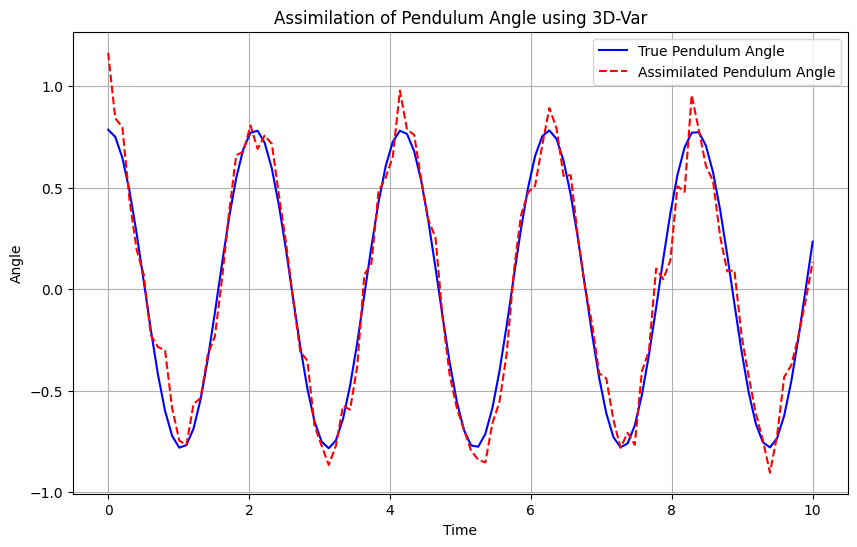

In [140]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def ThreeD_Var(xb, y, H, B, R):
    A = np.linalg.inv(B) + H.T @ np.linalg.inv(R) @ H

    b = (np.dot(np.linalg.inv(B), xb) + np.dot(H.T , np.dot(np.linalg.inv(R), y)))[:,0]
    xa = np.linalg.solve(A, b)

    return xa



observation_noise_std = 0.1
B = np.diag([0.1, 0.1])
R = np.array([[observation_noise_std**2]])
H = np.array([[1.0, 0.0]])

initial_state = [np.pi / 4, 0.0]
t_span = (0, 10)
t_eval = np.linspace(0, 10, 100)


sol = solve_ivp(pendulum_system, t_span, initial_state, t_eval=t_eval)
observation_noise_std = 0.1
observations = sol.y[0] + np.random.normal(0, observation_noise_std, sol.y[0].shape)

xb = initial_state + np.random.normal(0, 1, 2)
xa = xb
xa_list = []

for i in range(len(t_eval)):
    if i > 0:
        state = xa
        dt = t_eval[i] - t_eval[i-1]
        derivatives = pendulum_system(t_eval[i], state)
        xb = state + np.array(derivatives) * dt  # On utilise euler pour le background au lieu de prendre directement la ground_truth.
        xb = xb + np.random.normal(0, 0.1, 2)

    y= observations[i]
    xa = ThreeD_Var(xb, y, H, B, R)
    xa_list.append(xa)



xa_array = np.array(xa_list)
plt.figure(figsize=(10, 6))
plt.plot(t_eval, sol.y[0], label='True Pendulum Angle', color='blue')
plt.plot(t_eval, xa_array[:, 0], label='Assimilated Pendulum Angle', color='red', linestyle='--')
plt.title('Assimilation of Pendulum Angle using 3D-Var')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.legend()
plt.grid(True)
plt.show()


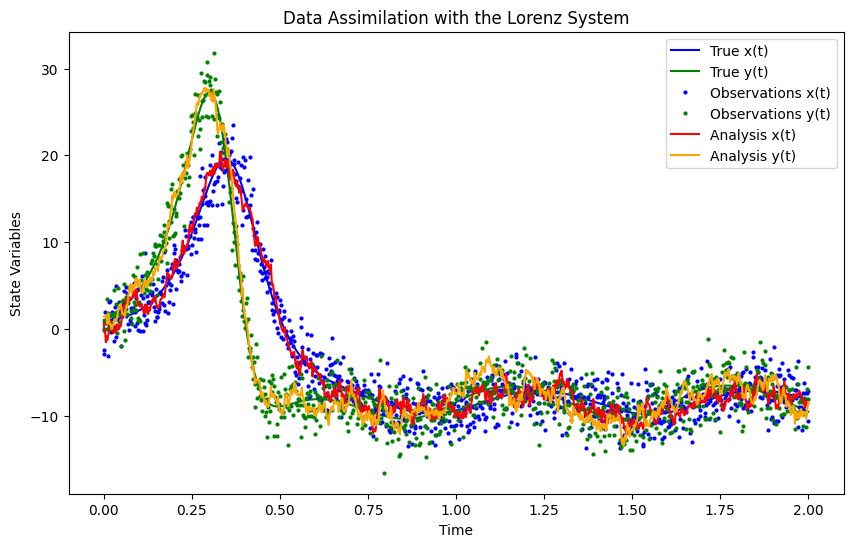

In [145]:

def ThreeD_Var(xb, y, H, B, R):
    A = np.linalg.inv(B) + H.T @ np.linalg.inv(R) @ H

    b = (np.dot(np.linalg.inv(B), xb) + np.dot(H.T , np.dot(np.linalg.inv(R), y)))
    xa = np.linalg.solve(A, b)

    return xa
initial_state = [1.0, 1.0, 1.0]

t_span = (0, 2)
t_eval = np.linspace(0, 2, 1000)
sol = solve_ivp(lorenz_system, t_span, initial_state, t_eval=t_eval)

observation_noise_std = 2.0
observations = sol.y[:2] + np.random.normal(0, observation_noise_std, sol.y[:2].shape)

H = np.array([[1, 0, 0],
              [0, 1, 0]])
B = np.diag([0.5, 0.5, 0.5])
R = np.diag([observation_noise_std**2, observation_noise_std**2])
xa_list = []
Pa_list = []
xb = initial_state + np.random.normal(0, 1, 3)
xa = xb
for i in range(len(t_eval)):
    if i > 0:
        state = xa
        dt = t_eval[i] - t_eval[i-1]
        derivatives = lorenz_system(t_eval[i], state)
        xb = state + np.array(derivatives) * dt
        xb = xb + np.random.normal(0, 0.5, 3)
    y = observations[:, i]
    xa = ThreeD_Var(xb, y, H, B, R)
    xa_list.append(xa)
    Pa_list.append(Pa)

xa_array = np.array(xa_list)
plt.figure(figsize=(10, 6))

plt.plot(sol.t, sol.y[0], label='True x(t)', color='blue')
plt.plot(sol.t, sol.y[1], label='True y(t)', color='green')
plt.plot(sol.t, observations[0], 'o', label='Observations x(t)', color='blue', markersize=2)
plt.plot(sol.t, observations[1], 'o', label='Observations y(t)', color='green', markersize=2)
plt.plot(sol.t, xa_array[:, 0], label='Analysis x(t)', color='red')
plt.plot(sol.t, xa_array[:, 1], label='Analysis y(t)', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Data Assimilation with the Lorenz System')
plt.show()